# Recommendation Systems Assignment

### MIE451/1513 UofT

Yuchao Wu 1000651984

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [0]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=e513097fde15c7ef816de8d0b54643c4eb9cc40e9a61c84ada2959fab2f2bb6e
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [0]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [0]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    matrix = np.zeros((num_users,num_items),dtype = np.int8)
    
    for (index,userID,itemID,rating,timestamp) in rating_df.itertuples():
      matrix [userID-1,itemID-1] = rating

    ###########         end         ###########
    return matrix

In [0]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        for (user,item),rating in np.ndenumerate(train_matrix):
          #if rating == 0:
          userVector = train_matrix[user,:]
          ratedItems = userVector [userVector.nonzero()] # extract the itmes the user rated
          if ratedItems.size == 0:
            itemAvg = 0
          else:
            itemAvg = ratedItems.mean()
          predictionMatrix [user, item] = itemAvg

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items): # iterate through each item-column
          # train_matrix [:, item] prints all the user rows at one particular item column
          #[0] has no actual meaning, but select the entire item's column (the second column)
          numOfUsersRated = len(train_matrix[:, item].nonzero()[0]) 
          numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
          if numOfUsersRated == 0:
            itemPopularity[item] = 0
          else:
            itemPopularity[item] = numOfUsersLiked/numOfUsersRated
          
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            #if rating == 0:
            predictionMatrix[user, item] = itemPopularity[item]
   
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [0]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
x = popularity_recsys.getModel()

In [0]:
np.all(x<=1)

True

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:31, 1093.79it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [0]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [0]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:30, 1106.60it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Q2

### (a)

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########
        similarity_matrix = pairwise_distances(matrix,metric = 'euclidean')
        similarity_matrix = 1/(1+similarity_matrix) # convert Euclidean distance to similarity score
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        Corr_d = pairwise_distances(matrix,metric ='correlation') # compute the correlation distance between the vectots
        similarity_matrix = abs(1-Corr_d)
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape) # tain_matrix: 943 x 1682
            temp_matrix[train_matrix.nonzero()] = 1 # set non-zeros to 1
            uu_similarity = self.method(train_matrix) # compute the similarity matrix
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5 # set 0 to 1e-5

            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            # Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            # output the predictionMatrix
            self.__model = predictionMatrix

            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            train_matrix = train_matrix.T # redefine the train_matrix
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5 # set 0 to 1e-5

            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            # Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            # output/return the predictionMatrix
            self.__model = predictionMatrix.T
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [0]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [0]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [0]:
SimBasedRecSys.somethingelse(I)

array([[1. , 0.5, 0.5],
       [0.5, 1. , 0.5],
       [0.5, 0.5, 1. ]])

Cosine similairty basically noralizes the distance. Cosine similarity is better because even if the two similar documents are far apart by the Euclidean distance (due to the size of the document), chances are they may still be oriented closer together. The smaller the angle, higher the cosine similarity.

### (b)

I would try correlation for calcualting the similarity. Correlaiton is unit independent. For example, when we scale one of the objects many 5 times, we would get different euclidean distances but same correlation distances. Unlike the cosine, the correlation is invariant to both scale and location changes of x and y

As noted in the code, absolute correlation is used as a distance metric because we are more interested in the strength of the relationship than in its sign.

## Q3

### (a)

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:30, 1107.91it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [0]:
#For item
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)
item_cosine_recsys.getModel()

array([[3.75429099, 3.66419957, 3.73222997, ..., 3.60248287, 3.79662696,
        3.90232044],
       [3.83658867, 3.80424519, 3.77473905, ..., 3.72798332, 3.9109779 ,
        3.79775927],
       [2.84492718, 2.89389328, 2.84327324, ..., 2.99504451, 3.16444153,
        2.9858119 ],
       ...,
       [4.11427954, 4.0558267 , 4.00963139, ..., 4.        , 3.87872799,
        4.14814803],
       [4.37096823, 4.39679254, 4.33543016, ..., 3.955358  , 4.41891089,
        4.57995134],
       [3.52030345, 3.46948821, 3.52393064, ..., 0.        , 3.6110641 ,
        3.59656861]])

In [0]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:34, 1054.73it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


### (b)

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
# How to use CrossValidation Class?

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [item_cosine_recsys, 
                       user_cosine_recsys]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_patk = CrossValidation('RMSE')

In [0]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
Results_CV = cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
20000it [00:11, 1757.46it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
20000it [00:11, 1751.02it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
20000it [00:11, 1750.91it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
20000it [00:11, 1776.40it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
20000it [00:11, 1745.87it/s]


Processing algorithm user-cosine


20000it [00:11, 1748.43it/s]
20000it [00:11, 1765.54it/s]
20000it [00:11, 1744.87it/s]
20000it [00:11, 1737.85it/s]
20000it [00:11, 1744.39it/s]


In [0]:
# print the results
for key, item in Results_CV.items():
  print(key)
  print('5-Kfold CV socre:',item[0])
  print('Mean:',item[1])
  print('CI:',item[2:4])

item-cosine
5-Kfold CV socre: [1.0377631264364244, 1.0207280585350078, 1.0101820660011798, 1.0136832839209695, 1.0180579656376574]
Mean: 1.020082900106248
CI: [1.0068242686250732, 1.0333415315874226]
user-cosine
5-Kfold CV socre: [1.026449013124381, 1.0214387664779507, 1.0132940326457187, 1.0094003999022947, 1.0161883961525586]
Mean: 1.0173541216605808
CI: [1.009013080226148, 1.0256951630950135]


As shown above, User-User similarity (RMSE = 1.017) has a slightly better RMSE than item-item (RMSE = 1.020). This is because the average number of rating per user is larger than the average number of rating per item, which means we have more zeros for item'ratings than the users' rating.

## Q4

### (a)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = 0.1 * np.random.randn(num_item,self.num_feat) +0  # item M x D 
        self.w_User = 0.1* np.random.randn(num_user,self.num_feat)+0  # user N x D 
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID,:],self.w_Item[batch_ItemID,:]),axis =1) #size (batch_size, )
            
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out =np.sum(np.multiply(self.w_User[train_user_idx,:],self.w_Item[train_item_idx,:]),axis = 1)# size(pairs_train, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out =  pred_out =np.sum(np.multiply(self.w_User[val_user_idx,:],self.w_Item[val_item_idx,:]),axis = 1)#size(pairs_val, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 100, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})

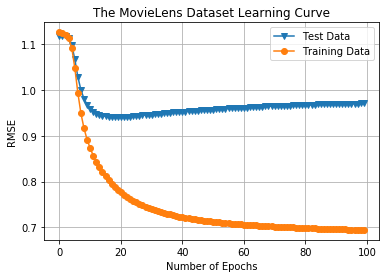

In [0]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

As shown above, the best maxepoch is found to be approximately 20. As shown, the RMSE remains almost a constant after 20 Epoches. The overfit is also observed after the 20th epoches.

In [0]:
# set the test_mode to false
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 100, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

## Q5

### (a)

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances_v2 = [popularity_recsys,average_user_rating_recsys,item_cosine_recsys, user_cosine_recsys,pmf]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
metrics = ['RMSE','P@K','R@K']

In [0]:
#3. Run CV by giving:
Results = []
for m in metrics:
  cv_patk = CrossValidation(m)
  result = cv_patk.run(algorithm_instances_v2,num_users,num_items,k=5)
  Results.append(result)

In [0]:
# extract and organize the resutls
# position 0: 5 cv scores
# position 1: mean
# position 2: CI - lower bound
# position 3: CI - upper bouond

Methods_all = list(Results[0].keys())

length = len(metrics)
AVG_list =[]

for i in range(length):
  Mean_list = [] # reset the mean list under each metric
  for method in  Methods_all:
    Mean = Results [i][method][1]
    Mean_list.append(Mean)
  AVG_list.append(Mean_list)

In [0]:
# Print the average socres for each metric and algorithm
pd.DataFrame(AVG_list,columns = Methods_all,index = ['RMSE','P@K','R@K'])

,popularity,useraverage,item-cosine,user-cosine,PMF
RMSE,3.159093,1.043718,1.020083,1.017354,0.967999
P@K,0.550583,0.473637,0.532216,0.555843,0.547232
R@K,0.484076,0.441323,0.474971,0.486269,0.482037


### (b)

We cannot evaluaute popularity based recommendation with RMSE. Popularity is a percentage of number of people gave the high rating and number of people who have rated. It is not a prediction of rating score (1 to 5) and is a ratio between 0 to 1. Thus, we cannot mesuare it with RMSE (mesaue the error between true and predicted score), but by some ranking based metrics.

###(C)

- RMSE: PMF is best for RMSE as it is used to minimize the MSE between the actual and predicted ratings.
- P@K and R@K: popularity is good for precision as it tends to find the most popular items based on the # of liked / # of rated.

### (d)

Good RMSE performacne could indicate a better prediction or less errors, which could lead to a better ranking. However, a good ranking score may not mean a good RMSE because rankning.

## Q6

### (a)

In [0]:
# the follwoing code is directly copied from lab materials
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [0]:
# Select the movies
moviesSelected = ['Heavy Metal (1981)','Theodore Rex (1995)','Operation Dumbo Drop (1995)']

In [0]:
# Extract the movie name 
Moive_name = moviesDF['movieTitle'].values
type(Moive_name)

numpy.ndarray

In [0]:
# Build a cosine similarity matrix
Rating_matrix = dataPreprocessor(rating_df,num_users,num_items).T
Sim_matrix = SimBasedRecSys.cosine(Rating_matrix)
Sim_matrix_df = pd.DataFrame(Sim_matrix,columns = Moive_name,index = Moive_name)
Sim_matrix_df.head()

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),Seven (Se7en) (1995),"Usual Suspects, The (1995)",Mighty Aphrodite (1995),"Postino, Il (1994)",Mr. Holland's Opus (1995),French Twist (Gazon maudit) (1995),From Dusk Till Dawn (1996),"White Balloon, The (1995)",Antonia's Line (1995),Angels and Insects (1995),Muppet Treasure Island (1996),Braveheart (1995),Taxi Driver (1976),Rumble in the Bronx (1995),"Birdcage, The (1996)","Brothers McMullen, The (1995)",Bad Boys (1995),Apollo 13 (1995),Batman Forever (1995),Belle de jour (1967),Crimson Tide (1995),Crumb (1994),Desperado (1995),"Doom Generation, The (1995)",Free Willy 2: The Adventure Home (1995),Mad Love (1995),Nadja (1994),"Net, The (1995)",Strange Days (1995),"To Wong Foo, Thanks for Everything! Julie Newmar (1995)",...,Angel Baby (1995),Sudden Manhattan (1996),"Butcher Boy, The (1998)",Men With Guns (1997),Hana-bi (1997),"Niagara, Niagara (1997)","Big One, The (1997)","Butcher Boy, The (1998)","Spanish Prisoner, The (1997)",Temptress Moon (Feng Yue) (1996),Entertaining Angels: The Dorothy Day Story (1996),Chairman of the Board (1998),"Favor, The (1994)",Little City (1998),Target (1995),"Substance of Fire, The (1996)",Getting Away With Murder (1996),Small Faces (1995),"New Age, The (1994)",Rough Magic (1995),Nothing Personal (1995),8 Heads in a Duffel Bag (1997),"Brother's Kiss, A (1997)",Ripe (1996),"Next Step, The (1995)",Wedding Bell Blues (1996),MURDER and murder (1996),Tainted (1998),"Further Gesture, A (1996)",Kika (1993),Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
Toy Story (1995),1.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,0.468291,0.460392,0.417509,0.347678,0.574377,0.224120,0.273916,0.046232,0.191772,0.232930,0.339196,0.527169,0.338105,0.467598,0.567950,0.227295,0.208472,0.592877,0.361657,0.150959,0.439441,0.259257,0.288536,0.090654,0.136757,0.108560,0.069805,0.368420,0.278386,0.246123,...,0.065390,0.010550,0.023592,0.014155,0.023592,0.023592,0.023592,0.023592,0.023592,0.014226,0.0,0.058979,0.047183,0.032856,0.035387,0.048189,0.058979,0.058979,0.035387,0.0,0.0,0.067404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033363,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
GoldenEye (1995),0.402382,1.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,0.468506,0.459946,0.213972,0.125463,0.253162,0.098185,0.390438,0.113063,0.030692,0.091550,0.319308,0.483349,0.278182,0.434907,0.306639,0.206481,0.408737,0.483077,0.581119,0.089355,0.462797,0.160738,0.479187,0.072342,0.087347,0.215247,0.184592,0.562970,0.334570,0.256668,...,0.049324,0.035017,0.078299,0.046980,0.078299,0.078299,0.078299,0.078299,0.078299,0.000000,0.0,0.000000,0.078299,0.000000,0.104399,0.000000,0.000000,0.000000,0.104399,0.0,0.0,0.074571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055366,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
Four Rooms (1995),0.330245,0.273069,1.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,0.361165,0.319295,0.271402,0.190242,0.266335,0.167609,0.404239,0.126564,0.105377,0.187733,0.194546,0.293732,0.233814,0.381910,0.306447,0.214125,0.261303,0.269296,0.253074,0.126347,0.259129,0.185187,0.404930,0.179008,0.046315,0.073332,0.051270,0.240534,0.277311,0.176729,...,0.036615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009736,0.0,0.000000,0.096875,0.000000,0.000000,0.000000,0.064583,0.064583,0.096875,0.0,0.0,0.018452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
Get Shorty (1995),0.454938,0.502571,0.324866,1.000000,0.334239,0.090308,0.489283,0.490236,0.41

In [0]:
# print the top most similar movies for each chosen movie
for m in moviesSelected:
  print("The top 5 most similar movies for {} ".format(m))
  print(Sim_matrix_df[m].sort_values(ascending = False)[1:6],'\n')

The top 5 most similar movies for Heavy Metal (1981) 
Highlander (1986)                         0.506291
Star Trek: Generations (1994)             0.464439
Bram Stoker's Dracula (1992)              0.463677
Star Trek: The Wrath of Khan (1982)       0.462372
Nightmare Before Christmas, The (1993)    0.458543
Name: Heavy Metal (1981), dtype: float64 

The top 5 most similar movies for Theodore Rex (1995) 
Picture Bride (1995)           0.402187
Sum of Us, The (1994)          0.329929
Lassie (1994)                  0.320256
Stefano Quantestorie (1993)    0.277350
Low Life, The (1994)           0.277350
Name: Theodore Rex (1995), dtype: float64 

The top 5 most similar movies for Operation Dumbo Drop (1995) 
Junior (1994)                    0.490405
Angels in the Outfield (1994)    0.450558
Santa Clause, The (1994)         0.428000
Made in America (1993)           0.407862
Corrina, Corrina (1994)          0.401123
Name: Operation Dumbo Drop (1995), dtype: float64 



### (b)

Yes we can justify these similarities. 
- "Heavy Metal (1981)": it is categorized as action, adventure, animation, horror and SciFi. Out of five similar movies, 4 movies have similiar types, suvh as they all belong to action,adventure and SCIFI. As shown below.
- "Theodore Rex (1995)": It is categorized as comedy. Two of the five similiar movies are also comdy moives.
- "Operation Dumbo Drop (1995)': It is categorized as action, adventure, comedy and war. All the five similiar movies are comedy movies. 

In [0]:
# View the types of movie for each similar moive
filter_list = ["Heavy Metal (1981)","Highlander (1986)","Star Trek: Generations (1994)","Bram Stoker's Dracula (1992)","Star Trek: The Wrath of Khan (1982)","Nightmare Before Christmas, The (1993)"]
moviesDF[moviesDF.movieTitle.isin(filter_list)]

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
90,91,"Nightmare Before Christmas, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Nightmare%20B...,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
100,101,Heavy Metal (1981),08-Mar-1981,NaN,http://us.imdb.com/M/title-exact?Heavy%20Metal...,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
216,217,Bram Stoker's Dracula (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Bram%20Stoker...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
227,228,Star Trek: The Wrath of Khan (1982),01-Jan-1982,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
379,380,Star Trek: Generations (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
430,431,Highlander (1986),01-Jan-1986,NaN,http://us.imdb.com/M/title-exact?Highlander%20...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
filter_list = ["Picture Bride (1995)","Sum of Us, The (1994)","Lassie (1994)","Stefano Quantestorie (1993)","Low Life, The (1994)","Theodore Rex (1995)"]
moviesDF[moviesDF.movieTitle.isin(filter_list)]

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
103,104,Theodore Rex (1995),29-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Theodore%20Re...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1030,1031,Lassie (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Lassie%20(1994),0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1166,1167,"Sum of Us, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Sum%20of%20Us...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1328,1329,"Low Life, The (1994)",10-May-1996,NaN,"http://us.imdb.com/Title?Low+Life,+The+(1994/I)",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1338,1339,Stefano Quantestorie (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Stefano%20Qua...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1399,1400,Picture Bride (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Picture%20Bri...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [0]:
filter_list = ["Operation Dumbo Drop (1995)","Junior (1994)","Angels in the Outfield (1994)","Santa Clause, The (1994)","Made in America (1993)","Corrina, Corrina (1994)"]
moviesDF[moviesDF.movieTitle.isin(filter_list)]

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
62,63,"Santa Clause, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Santa%20Claus...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
109,110,Operation Dumbo Drop (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Operation%20D...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
622,623,Angels in the Outfield (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Angels%20in%2...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
727,728,Junior (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Junior%20(1994),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
730,731,"Corrina, Corrina (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Corrina,%20Co...",0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
733,734,Made in America (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Made%20in%20A...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Q7

### (a)

In [0]:
# Select the userID and rating columns
# groupby the userID and find the counts (number of ratings) for each rating
# reset the index
new_df = rating_df[['userID','rating']].groupby('userID').count().reset_index()
new_df

,userID,rating
0,1,272
1,2,62
2,3,54
3,4,24
4,5,175
...,...,...
938,939,49
939,940,107
940,941,22
941,942,79


Text(0, 0.5, 'number of users')

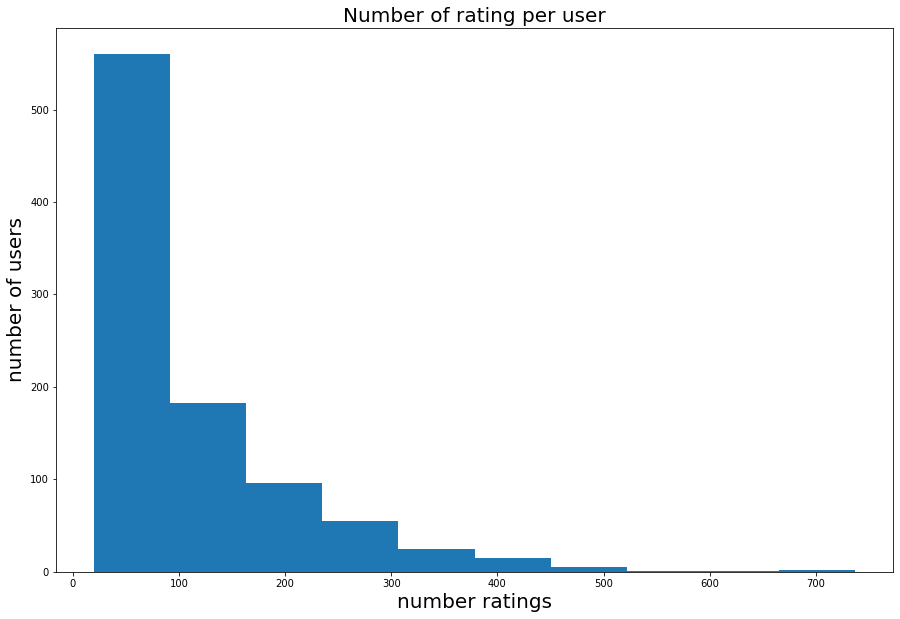

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,10))

plt.hist(new_df['rating'])
plt.title("Number of rating per user",fontsize=20)
plt.xlabel("number ratings",fontsize=20)
plt.ylabel("number of users",fontsize=20)


As shwon above, setting threshold as 150 could seperate the all the users to those with few ratings ad those with a moderate to large # of ratings.

In [0]:
threshold = 100

In [0]:
# Above the threshold
userID_above = new_df[new_df['rating'] >= threshold].userID.tolist()
# Bwlow the threshold
userID_below = new_df[new_df['rating'] < threshold].userID.tolist()

In [0]:
# Above the threshold data frame
userID_above_df = rating_df [rating_df['userID'].isin(userID_above)]
# Bwlow the threshold data frame
userID_below_df = rating_df [rating_df['userID'].isin(userID_below)]

In [0]:
def rmse(pred, test):
    # calculate RMSE for all the items in the test dataset
    predItems = pred[test.nonzero()].flatten() # return a copy of the array collapsed into one dimension
    testItems = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predItems, testItems))

In [0]:
# User - User (above threshold) prediction
user_User_above = SimBasedRecSys('user','cosine')
user_User_above.predict_all(userID_above_df, num_users, num_items)
user_User_above.getModel() # get the prediction matrix
Y_pred_user_up = user_User_above.evaluate_test(userID_above_df,copy=True)
#Y_pred_user_up.iloc[:,4]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
74522it [00:48, 1526.51it/s]


In [0]:
# User - User (Below Threshold) prediction
user_User_below = SimBasedRecSys('user','cosine')
user_User_below.predict_all(userID_below_df, num_users, num_items)
user_User_below.getModel() # get the prediction matrix
Y_pred_user_below = user_User_below.evaluate_test(userID_below_df,copy=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
25478it [00:10, 2360.61it/s]


In [0]:
# Item to item (Above Threshold)
item_item_above = SimBasedRecSys('item','cosine')
item_item_above.predict_all(userID_above_df, num_users, num_items)
item_item_above.getModel() # get the prediction matrix
Y_pred_item_up = item_item_above.evaluate_test(userID_above_df,copy=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
74522it [00:50, 1483.39it/s]


In [0]:
# Item to item (Below Threshold)
item_item_below = SimBasedRecSys('item','cosine')
item_item_below.predict_all(userID_below_df, num_users, num_items)
item_item_below.getModel() # get the prediction matrix
Y_pred_item_below = item_item_below.evaluate_test(userID_below_df,copy=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
25478it [00:10, 2357.84it/s]


In [0]:
# View the rmse with different user types
print ("RMSE for user-user above threshold:",rmse(Y_pred_user_up.iloc[:,4].values,Y_pred_user_up['rating'].values))

print ("RMSE for user-user below threshold:",rmse(Y_pred_user_below.iloc[:,4].values,Y_pred_user_below['rating'].values))

print ("RMSE for item-item above threshold: ",rmse(Y_pred_item_up.iloc[:,4].values,Y_pred_item_up['rating'].values))

print ("RMSE for item-item below threshold:",rmse(Y_pred_item_below.iloc[:,4].values,Y_pred_item_below['rating'].values))


RMSE for user-user above threshold: 0.9481767606298663
RMSE for user-user below threshold: 0.8901312664100373
RMSE for item-item above threshold:  0.9946094755385316
RMSE for item-item below threshold: 0.8942223431150697


- User-user and item - item CF: The performance is better when above the threshold as we have more rating which could be used to train the model and fianlly get the better results.

# Validation

In [0]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [0]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [0]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [0]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validatePopularityRecSys()

### User Average Based Recommendation

In [0]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [0]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [0]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [0]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [0]:
validateCustomizedSim()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


### User-User Similarity Based Recommendation System

In [0]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUUSimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [0]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateIISimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide


### Probabilistic Matrix Factorization Recommendation System

In [0]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [0]:
validatePMFRecSys(validation_df=validation_df)